# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [189]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

In [190]:
df_filled[(df_.sales.isnull()) | (df_.sales <= 0)]

,sales
week,
2010-01-03,0.0
2011-01-02,0.0


In [191]:
df_

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00
...,...
2011-11-13,229378.01
2011-11-20,221870.29
2011-11-27,210741.76


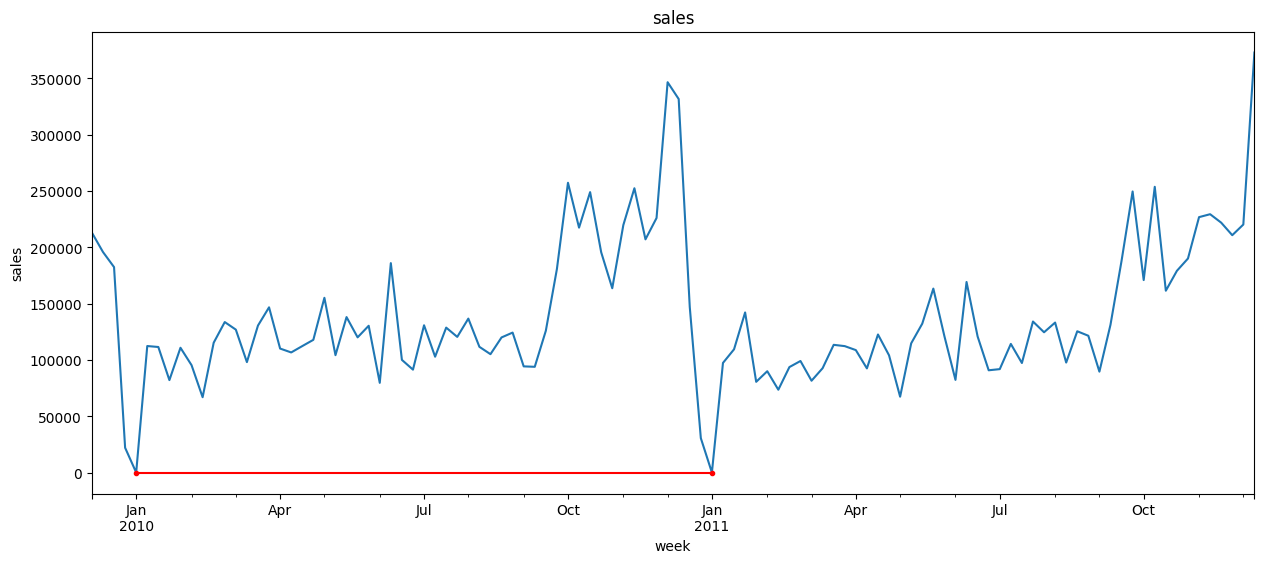

In [192]:
ax = df["sales"].plot(figsize=(15, 6));

df_ = df.asfreq("1W")
df_filled = df_.fillna(method="ffill")
df_filled[(df_.sales.isnull()) | (df_.sales <= 0)].sales.plot(legend=None, marker=".", color="r", ax=ax)

plt.title("sales")
plt.ylabel("sales");
plt.show()

## Missing data

Check if there are missing values in the time series.

In [193]:
((df.sales.isnull()) | (df.sales <= 0)).sum()

2

## Missing timestamps

Check if there are missing timestamps in the index.

In [194]:
kek = df.asfreq("1W").fillna(method="ffill")
assert kek.index.shape[0] == df.index.shape[0]
assert kek[kek.sales.isna()].shape[0] == 0

## Seasonality

Does the time series show any obvious seasonal pattern?

In [195]:
# year seasonality

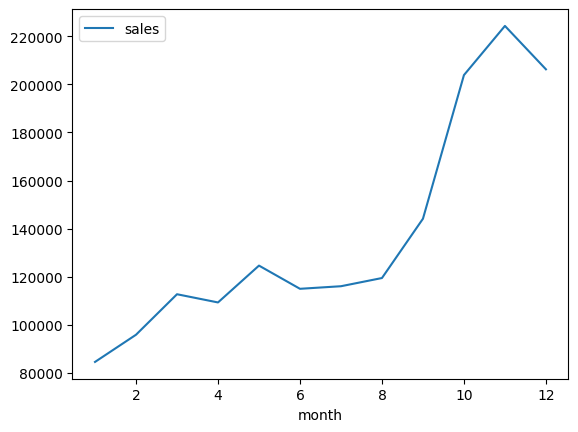

In [196]:
df["month"] = df.index.month
df.groupby("month").mean().plot();

# Feature engineering

Now, let's begin to tabularize the data.

In [197]:
tmp = df.sales.shift(freq="1W").rename(df.columns[0] + "_lag_1")

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 2)
data size after
(106, 3)


,sales,month,sales_lag_1
week,,,
2009-12-06,213000.35,12,NaN
2009-12-13,195810.04,12,213000.35
2009-12-20,182396.74,12,195810.04
2009-12-27,22007.77,12,182396.74
2010-01-03,0.00,1,22007.77


In [198]:
df.isnull().sum()

sales          0
month          0
sales_lag_1    1
dtype: int64

In [199]:
tmp = df.sales.shift(freq="4W").rename(df.columns[0] + "_lag_4")

# Add the features to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

data size before
(106, 3)
data size after
(106, 4)


In [200]:
df.head(10)

,sales,month,sales_lag_1,sales_lag_4
week,,,,
2009-12-06,213000.350,12,NaN,NaN
2009-12-13,195810.040,12,213000.350,NaN
2009-12-20,182396.740,12,195810.040,NaN
2009-12-27,22007.770,12,182396.740,NaN
2010-01-03,0.000,1,22007.770,213000.35
2010-01-10,112318.850,1,0.000,195810.04
2010-01-17,111460.470,1,112318.850,182396.74
2010-01-24,82065.331,1,111460.470,22007.77
2010-01-31,110790.591,1,82065.331,0.00


df.isnull().sum()

In [201]:
# Use the mean of the 3 previous weeks as input variables.

tmp = (
    df.sales
    .rolling(window=3)
    .agg({"mean_window":"mean", "std_window":"std", "max_window":"max", "min_window":"min"}) # Average, Std, Min, Max the last 3 wk values.
    .shift(1)  # Move the average 1 week forward
)


In [202]:
# Join the new variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head(10)

data size before
(106, 4)
data size after
(106, 8)


,sales,month,sales_lag_1,sales_lag_4,mean_window,std_window,max_window,min_window
week,,,,,,,,
2009-12-06,213000.350,12,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.040,12,213000.350,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.740,12,195810.040,NaN,NaN,NaN,NaN,NaN
2009-12-27,22007.770,12,182396.740,NaN,197069.043333,15340.601465,213000.35,182396.740
2010-01-03,0.000,1,22007.770,213000.35,133404.850000,96705.538769,195810.04,22007.770
2010-01-10,112318.850,1,0.000,195810.04,68134.836667,99563.660038,182396.74,0.000
2010-01-17,111460.470,1,112318.850,182396.74,44775.540000,59520.244702,112318.85,0.000
2010-01-24,82065.331,1,111460.470,22007.77,74593.106667,64600.951043,112318.85,0.000
2010-01-31,110790.591,1,82065.331,0.00,101948.217000,17224.432380,112318.85,82065.331


In [203]:
# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=["month"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

In [204]:
df

,sales,month,sales_lag_1,sales_lag_4,mean_window,std_window,max_window,min_window,month_sin,month_cos
week,,,,,,,,,,
2009-12-06,213000.35,12,NaN,NaN,NaN,NaN,NaN,NaN,-2.449294e-16,1.000000
2009-12-13,195810.04,12,213000.35,NaN,NaN,NaN,NaN,NaN,-2.449294e-16,1.000000
2009-12-20,182396.74,12,195810.04,NaN,NaN,NaN,NaN,NaN,-2.449294e-16,1.000000
2009-12-27,22007.77,12,182396.74,NaN,197069.043333,15340.601465,213000.35,182396.74,-2.449294e-16,1.000000
2010-01-03,0.00,1,22007.77,213000.35,133404.850000,96705.538769,195810.04,22007.77,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.01,11,226770.53,161438.54,198636.933333,24969.590553,226770.53,179106.07,-5.000000e-01,0.866025
2011-11-20,221870.29,11,229378.01,179106.07,215394.246667,22001.107090,229378.01,190034.20,-5.000000e-01,0.866025
2011-11-27,210741.76,11,221870.29,190034.20,226006.276667,3811.761701,229378.01,221870.29,-5.000000e-01,0.866025


In [205]:
# Determine fraction of missing data.

df.isnull().sum() / len(df)

sales          0.000000
month          0.000000
sales_lag_1    0.009434
sales_lag_4    0.037736
mean_window    0.028302
std_window     0.028302
max_window     0.028302
min_window     0.028302
month_sin      0.000000
month_cos      0.000000
dtype: float64

In [206]:
print("data size before")
print(df.shape)

df.dropna(inplace=True)

print("data size after")
print(df.shape)

data size before
(106, 10)
data size after
(102, 10)


In [207]:
df

,sales,month,sales_lag_1,sales_lag_4,mean_window,std_window,max_window,min_window,month_sin,month_cos
week,,,,,,,,,,
2010-01-03,0.000,1,22007.770,213000.35,133404.850000,96705.538769,195810.04,22007.770,5.000000e-01,0.866025
2010-01-10,112318.850,1,0.000,195810.04,68134.836667,99563.660038,182396.74,0.000,5.000000e-01,0.866025
2010-01-17,111460.470,1,112318.850,182396.74,44775.540000,59520.244702,112318.85,0.000,5.000000e-01,0.866025
2010-01-24,82065.331,1,111460.470,22007.77,74593.106667,64600.951043,112318.85,0.000,5.000000e-01,0.866025
2010-01-31,110790.591,1,82065.331,0.00,101948.217000,17224.432380,112318.85,82065.331,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.010,11,226770.530,161438.54,198636.933333,24969.590553,226770.53,179106.070,-5.000000e-01,0.866025
2011-11-20,221870.290,11,229378.010,179106.07,215394.246667,22001.107090,229378.01,190034.200,-5.000000e-01,0.866025
2011-11-27,210741.760,11,221870.290,190034.20,226006.276667,3811.761701,229378.01,221870.290,-5.000000e-01,0.866025


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [208]:
df.loc["2011-09-01": "2011-09-30"]

,sales,month,sales_lag_1,sales_lag_4,mean_window,std_window,max_window,min_window,month_sin,month_cos
week,,,,,,,,,,
2011-09-04,89577.650,9,121444.74,133155.37,114839.176667,15016.856121,125420.95,97651.84,-1.0,-1.836970e-16
2011-09-11,131164.240,9,89577.65,97651.84,112147.780000,19647.153424,125420.95,89577.65,-1.0,-1.836970e-16
2011-09-18,187934.500,9,131164.24,125420.95,114062.210000,21754.020981,131164.24,89577.65,-1.0,-1.836970e-16
2011-09-25,249563.051,9,187934.50,121444.74,136225.463333,49373.368041,187934.50,89577.65,-1.0,-1.836970e-16


In [209]:
X_train = df[df.index <= "2011-09-26"]
X_test = df[df.index > "2011-09-26"]

X_train.shape, X_test.shape

((91, 10), (11, 10))

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [210]:
# the target variable
y_train = X_train.sales.copy()
y_test = X_test.sales.copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

In [211]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  45844.30745262792
test rmse:  65327.34284108387


## Machine Learning

In [225]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [226]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  27884.012405615013
test rmse:  51000.02423834214


Text(0, 0.5, 'Importance')

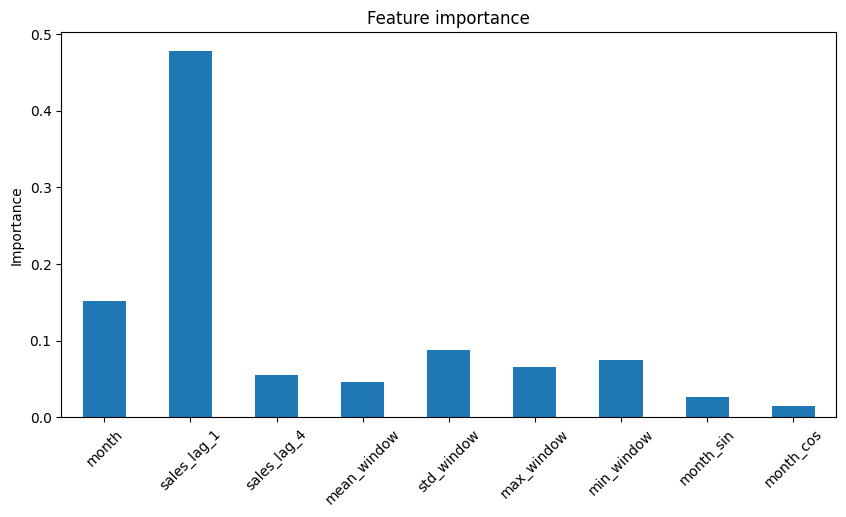

In [227]:
# Let's now plot the feature's importance
# according to the random forests.

# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

In [228]:
linear_model = Lasso(alpha=10, random_state=0)

linear_model.fit(X_train, y_train)

/Users/dmitry/Dev/feature-engineering-for-time-series-forecasting/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.037e+10, tolerance: 2.932e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=10, random_state=0)

In [229]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  33247.87079447196
test rmse:  47939.074261881


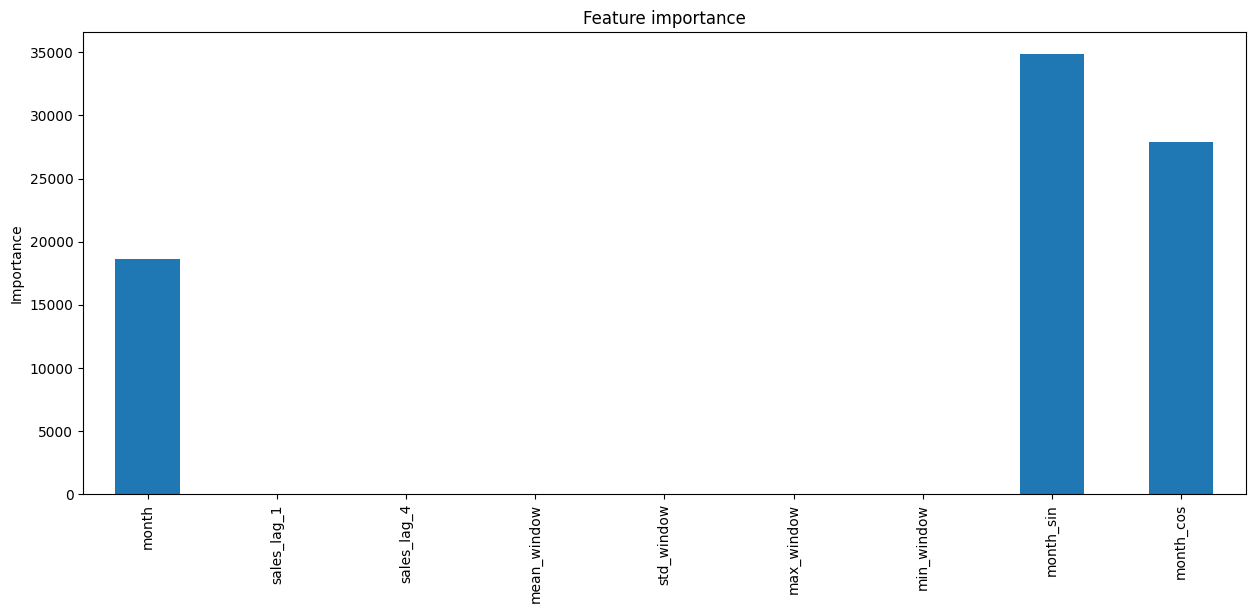

In [230]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance");